In [1]:
from shutil import copy 
from collections import defaultdict
import os

In [2]:
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')


Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying images into  croque_madam

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
n_classes = 101
img_width, img_height = 299, 299
train_data_dir = 'food-101/train'
validation_data_dir = 'food-101/test'
nb_train_samples = 75750
nb_validation_samples = 25250
batch_size = 20

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [6]:
mbv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape = (299,299,3))
mbv2.trainable = False
model = tf.keras.Sequential([
    mbv2,
    GlobalAveragePooling2D(),
    Dense(256,activation='relu'),
    Dropout(0.2),
    Dense(101,kernel_regularizer=regularizers.l2(0.005), activation='softmax')

])
model.compile(optimizer=SGD(lr=0.0005, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class_sept.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')

c:\Users\siyua\miniconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=5,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('base_model.h5')

C:\Users\siyua\AppData\Local\Temp\ipykernel_2924\911133930.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/5
3787/3787 [==============================] - ETA: 0s - loss: 4.4385 - accuracy: 0.1626
Epoch 1: val_loss improved from inf to 3.40158, saving model to best_model_3class_sept.hdf5
3787/3787 [==============================] - 1305s 342ms/step - loss: 4.4385 - accuracy: 0.1626 - val_loss: 3.4016 - val_accuracy: 0.3774
Epoch 2/5
3787/3787 [==============================] - ETA: 0s - loss: 3.3167 - accuracy: 0.3388
Epoch 2: val_loss improved from 3.40158 to 2.77020, saving model to best_model_3class_sept.hdf5
3787/3787 [==============================] - 1157s 306ms/step - loss: 3.3167 - accuracy: 0.3388 - val_loss: 2.7702 - val_accuracy: 0.4705
Epoch 3/5
3787/3787 [==============================] - ETA: 0s - loss: 2.9285 - accuracy: 0.3962
Epoch 3: val_loss improved from 2.77020 to 2.51900, saving model to best_model_3class_sept.hdf5
3787/3787 [==============================] - 923s 244ms/step - loss: 2.9285 - accuracy: 0.3962 - val_loss: 2.5190 - val_accuracy: 0.4985
Epoch 4/5
37

In [18]:
import matplotlib.pyplot as plt
def plotloss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','accuracy'])
    plt.show()

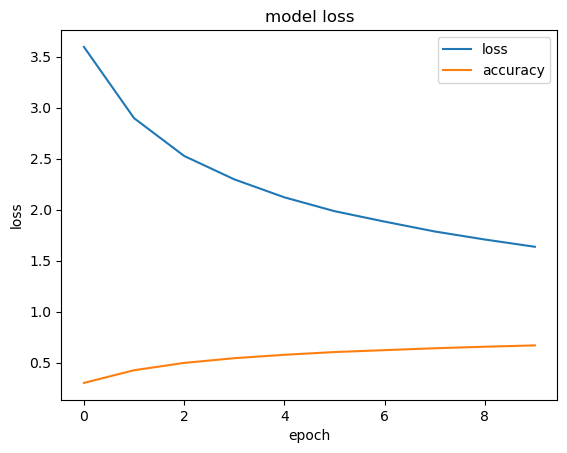

In [19]:
plotloss(history)

In [8]:
for layer in model.layers[-50:]:
    layer.trainable = True

In [9]:
model.compile(optimizer=SGD(lr=0.0005, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\siyua\miniconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=5,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('fineTune_model.h5')

C:\Users\siyua\AppData\Local\Temp\ipykernel_2924\3498540870.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/5
3787/3787 [==============================] - ETA: 0s - loss: 2.1127 - accuracy: 0.5366
Epoch 1: val_loss improved from 2.26999 to 1.44223, saving model to best_model_3class_sept.hdf5
3787/3787 [==============================] - 851s 224ms/step - loss: 2.1127 - accuracy: 0.5366 - val_loss: 1.4422 - val_accuracy: 0.6737
Epoch 2/5
3787/3787 [==============================] - ETA: 0s - loss: 1.6268 - accuracy: 0.6386
Epoch 2: val_loss improved from 1.44223 to 1.24109, saving model to best_model_3class_sept.hdf5
3787/3787 [==============================] - 834s 220ms/step - loss: 1.6268 - accuracy: 0.6386 - val_loss: 1.2411 - val_accuracy: 0.7218
Epoch 3/5
3787/3787 [==============================] - ETA: 0s - loss: 1.4233 - accuracy: 0.6808
Epoch 3: val_loss improved from 1.24109 to 1.23157, saving model to best_model_3class_sept.hdf5
3787/3787 [==============================] - 834s 220ms/step - loss: 1.4233 - accuracy: 0.6808 - val_loss: 1.2316 - val_accuracy: 0.7146
Epoch 4/5
